<a href="https://colab.research.google.com/github/yunju-1118/ESAA/blob/main/ESAA_YB3_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ESAA YB 3조 프로젝트**

https://www.kaggle.com/competitions/prediction-interval-competition-ii-house-price/overview

### **라이브러리 불러오기**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsRegressor
import lightgbm as lgb
from scipy.optimize import minimize

### **GPU 설정**

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


### **데이터 불러오기**

In [ ]:
house = pd.read_csv('dataset.csv')
test = pd.read_csv('test.csv')
#submission = pd.read_csv('sample_submission.csv')

In [ ]:
def check_missing_values(house):
    # 결측치 개수 계산
    missing_counts = house.isnull().sum()

    # 결측치가 있는 컬럼만 필터링
    missing_counts = missing_counts[missing_counts > 0]

    # 결측치 비율 계산
    missing_percentages = (missing_counts / len(house)) * 100

    # 결과 테이블 생성
    missing_df = pd.DataFrame({
        '결측치 개수': missing_counts,
        '결측치 비율 (%)': missing_percentages.round(2)
    })

    # 결측치 개수 기준으로 내림차순 정렬
    missing_df = missing_df.sort_values(by='결측치 개수', ascending=False)

    return missing_df

# 함수 실행 및 결과 출력
missing_info = check_missing_values(house)

if missing_info is not None:
    display(missing_info)

,결측치 개수,결측치 비율 (%)
sale_nbr,42182,21.09
subdivision,17550,8.77
submarket,1717,0.86


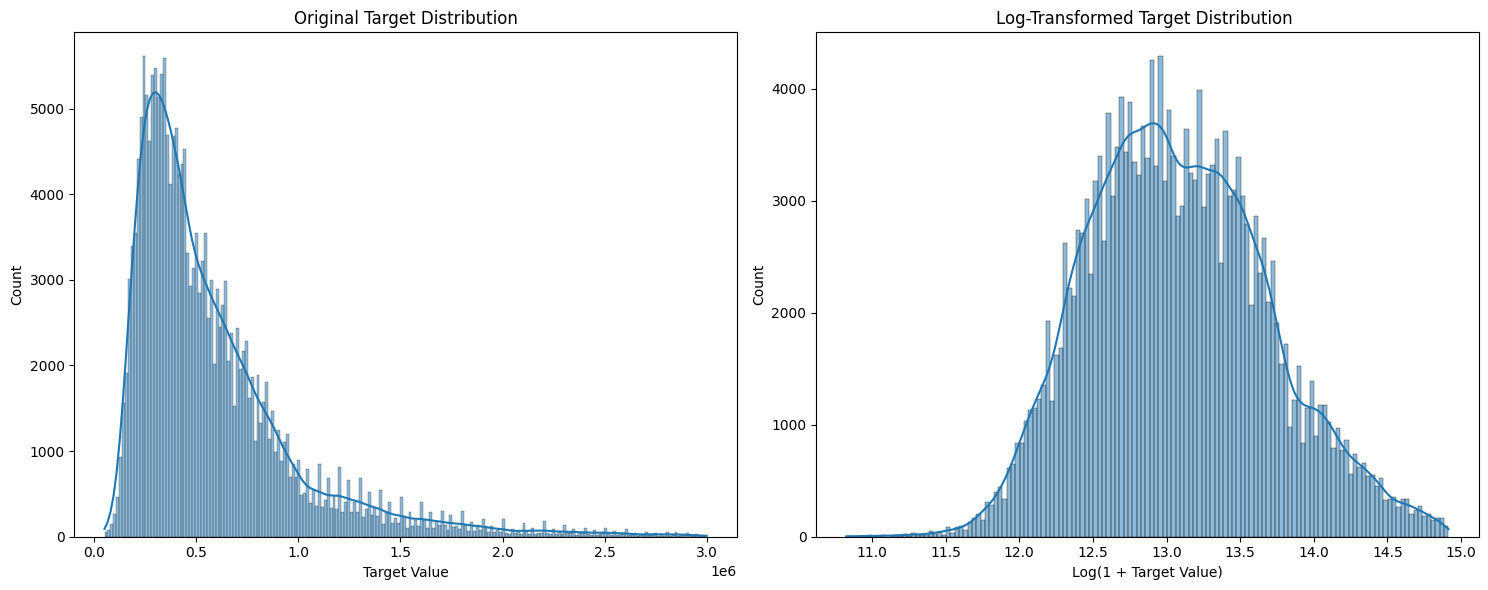

In [ ]:
# 두 개의 그래프를 나란히 그리기 위해 subplots 설정
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# 원본 타겟 변수 분포 시각화
sns.histplot(house['sale_price'], kde=True, ax=axes[0])
axes[0].set_title('Original Target Distribution')
axes[0].set_xlabel('Target Value')

# 로그 변환된 타겟 변수 분포 시각화
sns.histplot(np.log1p(house['sale_price']), kde=True, ax=axes[1])
axes[1].set_title('Log-Transformed Target Distribution ')
axes[1].set_xlabel('Log(1 + Target Value)')

# 그래프 출력
plt.tight_layout()
plt.show()

In [ ]:
# 날짜를 datetime 형식으로 변환
house = pd.read_csv('dataset.csv', parse_dates=['sale_date'])
house['year'] = house['sale_date'].dt.year
house['month'] = house['sale_date'].dt.month
house['quarter'] = house['sale_date'].dt.quarter

# land_val + imp_val -> 'total_val' 변수 생성
house['total_val'] = house['land_val'] + house['imp_val']

# bath_full + bath_3qtr + bath_half -> 'bath_total' 변수 생성
house['bath_total'] = house['bath_full'] + 0.75 * house['bath_3qtr'] + 0.5 * house['bath_half']

In [ ]:
# KNN NEIGHBORHOOD FEATURES

def retrieve_neighbours(model, X, y, k=5, exclude_0=False):
   X, y = np.array(X), np.array(y)
   distances, indices = model.kneighbors(X, n_neighbors=k + 1 if exclude_0 else k)
   preds, dists = [], []
   for d, idxs in zip(distances, indices):
       if exclude_0:
           d, idxs = d[1:], idxs[1:]
       preds.append(np.mean(y[idxs]))
       dists.append(np.mean(d))
   return np.array(preds), np.array(dists)

def preprocess_knn_features(X_tr, X_va, y_tr, knn_features, knn_params):
   scaler = StandardScaler()
   X_tr_knn, X_va_knn = scaler.fit_transform(X_tr[knn_features]), scaler.transform(X_va[knn_features])
   knn = KNeighborsRegressor(**knn_params).fit(X_tr_knn, y_tr)
   k = knn_params["n_neighbors"]
   price_tr, d_tr = retrieve_neighbours(knn, X_tr_knn, y_tr, k=k, exclude_0=True)
   price_va, d_va = retrieve_neighbours(knn, X_va_knn, y_tr, k=k, exclude_0=False)
   X_tr, X_va = X_tr.copy(), X_va.copy()
   X_tr["k_dist"], X_va["k_dist"] = d_tr, d_va
   X_tr["price_knn"], X_va["price_knn"] = price_tr, price_va
   return X_tr, X_va

In [ ]:
# effective_age 피처 생성
house['effective_year'] = house[['year_built', 'year_reno']].max(axis=1)
house['effective_age'] = house['year'] - house['effective_year']

# 월 기준 주기성 피처: 사인, 코사인 변환
house['month_sin'] = np.sin(2 * np.pi * house['month']/12)
house['month_cos'] = np.cos(2 * np.pi * house['month']/12)

# 분기 기준 주기성 피처: 사인, 코사인 변환
house['quarter_sin'] = np.sin(2 * np.pi * house['quarter']/4)
house['quarter_cos'] = np.cos(2 * np.pi * house['quarter']/4)

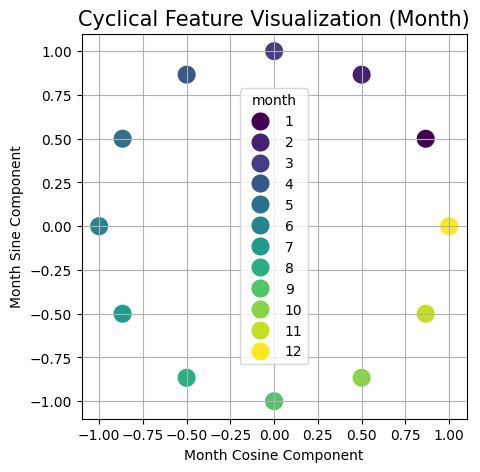

In [ ]:
# 월별로 그룹화하여 평균값 계산 (점이 겹치는 것을 방지)
df_monthly = house.groupby('month')[['month_sin', 'month_cos']].mean().reset_index()

plt.figure(figsize=(5, 5))
sns.scatterplot(data=df_monthly, x='month_cos', y='month_sin', s=200,
                hue='month', palette='viridis', legend='full')
plt.title('Cyclical Feature Visualization (Month)', fontsize=15)
plt.xlabel('Month Cosine Component')
plt.ylabel('Month Sine Component')
plt.grid(True)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

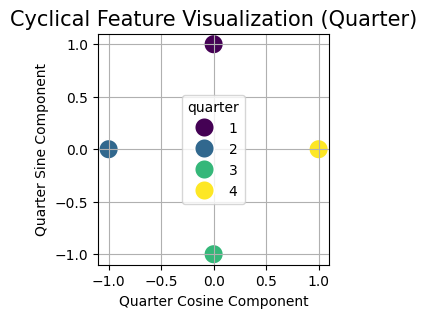

In [ ]:
# 분기별로 그룹화하여 평균값 계산
df_quarterly = house.groupby('quarter')[['quarter_sin', 'quarter_cos']].mean().reset_index()

# 시각화
plt.figure(figsize=(3, 3))
sns.scatterplot(data=df_quarterly, x='quarter_cos', y='quarter_sin', s=200,
                hue='quarter', palette='viridis', legend='full')
plt.title('Cyclical Feature Visualization (Quarter)', fontsize=15)
plt.xlabel('Quarter Cosine Component')
plt.ylabel('Quarter Sine Component')
plt.grid(True)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

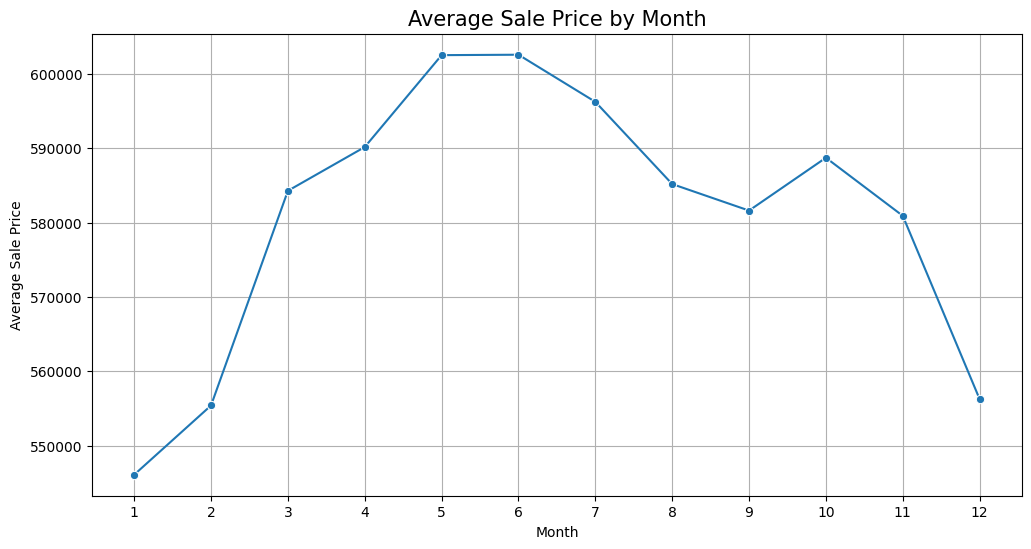

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=house, x='month', y='sale_price', errorbar=None, marker='o')
plt.title('Average Sale Price by Month', fontsize=15)
plt.xlabel('Month')
plt.ylabel('Average Sale Price')
plt.grid(True)
plt.xticks(range(1, 13)) # x축 눈금을 1월부터 12월까지 표시
plt.show()

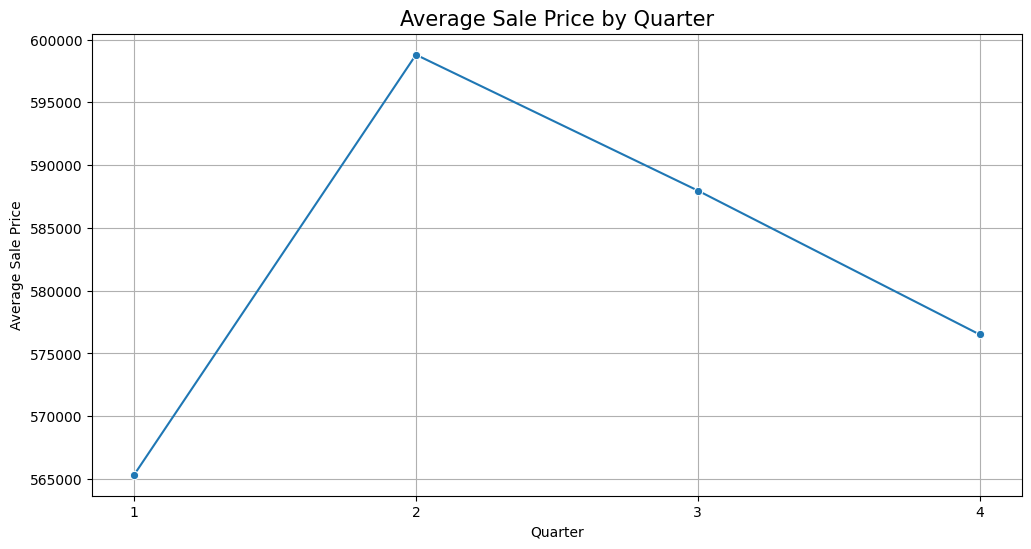

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=house, x='quarter', y='sale_price', errorbar=None, marker='o')
plt.title('Average Sale Price by Quarter', fontsize=15)
plt.xlabel('Quarter')
plt.ylabel('Average Sale Price')
plt.grid(True)
plt.xticks(range(1, 5))
plt.show()

In [ ]:
# 변수 삭제
cols_to_drop = [
    'submarket', 'subdivision', 'sale_nbr', 'sale_date', 'id',
    'land_val', 'imp_val',
    'bath_full', 'bath_3qtr', 'bath_half',
    'year_built', 'year_reno', 'effective_year',
    'month', 'quarter'
]
house.drop(columns=cols_to_drop, inplace=True, errors='ignore')

In [ ]:
cat_cols = [c for c in house.columns if house[c].dtype == 'object']
total_unique = sum(house[col].nunique() for col in cat_cols)
total_unique

691

### **필요한 함수 정의**

In [ ]:
def winkler_score(y_true, lower, upper, alpha=0.1, return_coverage=False):
   """Competitor's exact Winkler Score implementation."""
   y_true, lower, upper = np.asarray(y_true), np.asarray(lower), np.asarray(upper)
   width = upper - lower
   penalty_lower = 2 / alpha * (lower - y_true)
   penalty_upper = 2 / alpha * (y_true - upper)
   score = width + np.where(y_true < lower, penalty_lower, 0) + np.where(y_true > upper, penalty_upper, 0)
   if return_coverage:
       coverage = np.mean((y_true >= lower) & (y_true <= upper))
       return np.mean(score), coverage
   return np.mean(score)

### **새로운 피처 생성**

In [ ]:
# KNN NEIGHBORHOOD FEATURES

def retrieve_neighbours(model, X, y, k=5, exclude_0=False):
   X, y = np.array(X), np.array(y)
   distances, indices = model.kneighbors(X, n_neighbors=k + 1 if exclude_0 else k)
   preds, dists = [], []
   for d, idxs in zip(distances, indices):
       if exclude_0:
           d, idxs = d[1:], idxs[1:]
       preds.append(np.mean(y[idxs]))
       dists.append(np.mean(d))
   return np.array(preds), np.array(dists)

def preprocess_knn_features(X_tr, X_va, y_tr, knn_features, knn_params):
   scaler = StandardScaler()
   X_tr_knn, X_va_knn = scaler.fit_transform(X_tr[knn_features]), scaler.transform(X_va[knn_features])
   knn = KNeighborsRegressor(**knn_params).fit(X_tr_knn, y_tr)
   k = knn_params["n_neighbors"]
   price_tr, d_tr = retrieve_neighbours(knn, X_tr_knn, y_tr, k=k, exclude_0=True)
   price_va, d_va = retrieve_neighbours(knn, X_va_knn, y_tr, k=k, exclude_0=False)
   X_tr, X_va = X_tr.copy(), X_va.copy()
   X_tr["k_dist"], X_va["k_dist"] = d_tr, d_va
   X_tr["price_knn"], X_va["price_knn"] = price_tr, price_va
   return X_tr, X_va

### **모델 정의**

In [ ]:
# TWO-STAGE UNCERTAINTY MODEL

class TwoStageUncertaintyModel:
   def __init__(self, model0, model1, n_splits=5, method="squared_error", seed=None, lower_bound=1000, alpha=0.1, gamma0=1.65, gamma1=1.75, features1=None):
       self.model0, self.model1 = model0, model1
       self.n_splits, self.method, self.seed = n_splits, method, seed
       self.gamma0, self.gamma1 = gamma0, gamma1
       self.lower_bound, self.alpha, self.features1 = lower_bound, alpha, features1
       self.fitted_ = False

   def _prepare_features_for_model1(self, X, y_pred):
       X_tmp = X[self.features1].copy() if self.features1 != "same" else X.copy()
       X_tmp["y_pred"] = y_pred
       return X_tmp

   def _get_target(self, y, oof_preds):
       return (y - oof_preds) ** 2 + 1e-6 if self.method == "squared_error" else np.abs(y - oof_preds)

   def fit(self, X, y):
       y = np.asarray(y)
       oof_preds = np.zeros_like(y, dtype=float)
       kf = KFold(n_splits=self.n_splits, shuffle=True, random_state=self.seed)
       for house_idx, val_idx in kf.split(X):
           X_tr, X_val, y_tr = X.iloc[house_idx], X.iloc[val_idx], y[house_idx]
           self.model0.fit(X_tr, y_tr)
           oof_preds[val_idx] = self.model0.predict(X_val)
       target = self._get_target(y, oof_preds)
       X_resid_feat = self._prepare_features_for_model1(X, oof_preds) if self.features1 else oof_preds.reshape(-1, 1)
       self.model1.fit(X_resid_feat, target)
       self.model0.fit(X, y)
       self.fitted_ = True
       return self

   def predict_components(self, X):
       if not self.fitted_: raise ValueError("Call fit() before predict()")
       y_hat = self.model0.predict(X)
       X_resid_feat = self._prepare_features_for_model1(X, y_hat) if self.features1 else y_hat.reshape(-1, 1)
       err_hat = self.model1.predict(X_resid_feat)
       err_hat = np.maximum(err_hat, self.lower_bound)
       return y_hat, err_hat

   def build_interval(self, y_hat, err_hat):
       err_hat_sqrt = np.sqrt(err_hat) if self.method == "squared_error" else err_hat
       lower = y_hat - self.gamma0 * err_hat_sqrt
       upper = y_hat + self.gamma1 * err_hat_sqrt
       return lower, upper

   def predict(self, X):
       y_hat, err_hat = self.predict_components(X)
       lower, upper = self.build_interval(y_hat, err_hat)
       return y_hat, lower, upper

### **기타 전처리**

In [ ]:
# 날짜를 datetime 형식으로 변환
house = pd.read_csv('dataset.csv', parse_dates=['sale_date'])
house['year'] = house['sale_date'].dt.year
house['month'] = house['sale_date'].dt.month
house['quarter'] = house['sale_date'].dt.quarter

# land_val + imp_val = total_val
house['total_val'] = house['land_val'] + house['imp_val']

# bath_full, bath_3qtr, bath_half -> 'bath_total'
house['bath_total'] = house['bath_full'] + 0.75 * house['bath_3qtr'] + 0.5 * house['bath_half']

# effective_age 피처 생성
house['effective_year'] = house[['year_built', 'year_reno']].max(axis=1)
house['effective_age'] = house['year'] - house['effective_year']

# 월 기준 주기성 피처: 사인, 코사인 변환
house['month_sin'] = np.sin(2 * np.pi * house['month']/12)
house['month_cos'] = np.cos(2 * np.pi * house['month']/12)

# 분기 기준 주기성 피처: 사인, 코사인 변환
house['quarter_sin'] = np.sin(2 * np.pi * house['quarter']/4)
house['quarter_cos'] = np.cos(2 * np.pi * house['quarter']/4)

# 변수 삭제
cols_to_drop = [
    'submarket', 'subdivision', 'sale_nbr', 'sale_date', 'id',
    'land_val', 'imp_val',
    'bath_full', 'bath_3qtr', 'bath_half',
    'year_built', 'year_reno', 'effective_year',
    'month', 'quarter'
]
house.drop(columns=cols_to_drop, inplace=True, errors='ignore')

In [ ]:
# 날짜를 datetime 형식으로 변환
test = pd.read_csv('test.csv', parse_dates=['sale_date'])
test['year'] = test['sale_date'].dt.year
test['month'] = test['sale_date'].dt.month
test['quarter'] = test['sale_date'].dt.quarter

# land_val + imp_val = total_val
test['total_val'] = test['land_val'] + test['imp_val']

# bath_full, bath_3qtr, bath_half -> 'bath_total'
test['bath_total'] = test['bath_full'] + 0.75 * test['bath_3qtr'] + 0.5 * test['bath_half']

# effective_age 피처 생성
test['effective_year'] = test[['year_built', 'year_reno']].max(axis=1)
test['effective_age'] = test['year'] - test['effective_year']

# 월 기준 주기성 피처: 사인, 코사인 변환
test['month_sin'] = np.sin(2 * np.pi * test['month']/12)
test['month_cos'] = np.cos(2 * np.pi * test['month']/12)

# 분기 기준 주기성 피처: 사인, 코사인 변환
test['quarter_sin'] = np.sin(2 * np.pi * test['quarter']/4)
test['quarter_cos'] = np.cos(2 * np.pi * test['quarter']/4)

# 변수 삭제
cols_to_drop = [
    'submarket', 'subdivision', 'sale_nbr', 'sale_date', 'id',
    'land_val', 'imp_val',
    'bath_full', 'bath_3qtr', 'bath_half',
    'year_built', 'year_reno', 'effective_year',
    'month', 'quarter'
]
test.drop(columns=cols_to_drop, inplace=True, errors='ignore')

In [ ]:
cat_cols = [c for c in house.columns if house[c].dtype == 'object' and c != 'sale_price']
num_cols = list(set(test.columns) - set(cat_cols))

encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
house[cat_cols] = encoder.fit_transform(house[cat_cols]).astype(int)
test[cat_cols] = encoder.transform(test[cat_cols]).astype(int)
print(f"Data ready: house {house.shape}, Test {test.shape}")

Data ready: house (200000, 43), Test (200000, 42)


### **Model Fitting**

In [ ]:
# MODEL CONFIGURATION

# 기본 회귀 모델
knn_params = {'n_neighbors': 10}
lgb_params0 = {
    'n_estimators': 1500,
    'max_depth': 9,
    'learning_rate': 0.1,
    'random_state': 42,
    'subsample': 0.74,
    'objective': 'regression',   # 기본 L2 회귀
}

# 감마 회귀 모델
lgb_params1 = {
    'n_estimators': 1000,
    'max_depth': 4,
    'learning_rate': 0.1,
    'random_state': 42,
    'objective': 'gamma',        # LightGBM의 감마 회귀
}

model0 = lgb.LGBMRegressor(**lgb_params0)
model1 = lgb.LGBMRegressor(**lgb_params1)

uncert_model = TwoStageUncertaintyModel(
    model0=model0,
    model1=model1,
    seed=42,
    method="squared_error",
    n_splits=10,
    features1="same",
    gamma0=1.65,
    gamma1=1.75,
    lower_bound=1e-6
)

features = cat_cols + num_cols + ["price_knn", "k_dist"]
knn_features = ["latitude", "longitude", "year"]
y = house["sale_price"]
y_log = np.log1p(y)

In [ ]:
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor

# XGBoost 회귀 모델 설정
knn_params = {'n_neighbors': 10}
xgb_params0 = {
    'n_estimators': 1500,
    'max_depth': 6,
    'learning_rate': 0.05,
    'random_state': 42,
    'objective': 'reg:squarederror',
}

xgb_params1 = {
    'n_estimators': 1000,
    'max_depth': 4,
    'learning_rate': 0.1,
    'random_state': 42,
    'objective': 'reg:gamma',
}

model0 = XGBRegressor(**xgb_params0)
model1 = XGBRegressor(**xgb_params1)

# 최종 예측에 사용할 전체 피처 구성
features = cat_cols + num_cols + ["price_knn", "k_dist"]
knn_features = ["latitude", "longitude", "year"]
y = house["sale_price"]
y_log = np.log1p(y)

# 불확실성 추정 모델
uncert_model = TwoStageUncertaintyModel(
    model0=model0,
    model1=model1,
    seed=42,
    method="squared_error",
    n_splits=10,
    features1="same",
    gamma0=1.65,
    gamma1=1.75,
    lower_bound=1e-6
)

In [ ]:
# CROSS-VALIDATION & OOF PREDICTION COLLECTION

print(f"\n Running Cross-Validation and Collecting OOF Predictions...")
oof_y_true, oof_y_hat, oof_err_hat, oof_indices = [], [], [], []
scores, coverages = [], []
cv = KFold(shuffle=True, random_state=42, n_splits=5)
for i, (house_idx, val_idx) in enumerate(cv.split(house, y_log), 1):
    print(f"\n=== Fold: {i} ===")
    X_tr, X_vl = house.iloc[house_idx], house.iloc[val_idx]
    y_tr_log, y_vl_log = y_log.iloc[house_idx], y_log.iloc[val_idx] # 모델 학습용 (로그 스케일)
    y_tr_orig, y_vl_orig = y.iloc[house_idx], y.iloc[val_idx]       # 스코어 계산 및 clip용 (원본 스케일)
    X_tr, X_vl = preprocess_knn_features(X_tr, X_vl, y_tr_log, knn_features, knn_params)
    model = uncert_model.fit(X_tr[features], y_tr_log)
    y_hat_vl_log, err_hat_vl_log = model.predict_components(X_vl[features])
    pi_lower_log, pi_upper_log = model.build_interval(y_hat_vl_log, err_hat_vl_log)
    # 점수 계산 전, 예측 구간을 원래 스케일로 변환
    pi_lower = np.expm1(pi_lower_log)
    pi_upper = np.expm1(pi_upper_log)
    y_min, y_max = y_tr_orig.min(), y_tr_orig.max()
    pi_lower, pi_upper = np.clip(pi_lower, y_min, y_max), np.clip(pi_upper, y_min, y_max)
    score, coverage = winkler_score(y_vl_orig.values, pi_lower, pi_upper, alpha=0.1, return_coverage=True)
    scores.append(score)
    coverages.append(coverage)
    # OOF 데이터 저장: y_true는 원본, 예측값들은 로그 스케일로 저장 (감마 최적화에 사용)
    oof_y_true.extend(y_vl_orig.values)
    oof_y_hat.extend(y_hat_vl_log)
    oof_err_hat.extend(err_hat_vl_log)
    oof_indices.extend(val_idx)
    print(f"Winkler (fixed gamma): {score:,.0f} | Coverage: {coverage:.4f}")

oof_df = pd.DataFrame({'y_true': oof_y_true, 'y_hat': oof_y_hat, 'err_hat': oof_err_hat}, index=oof_indices).sort_index()
print(f"\n Initial CV Winkler (fixed gamma): {np.mean(scores):,.0f} ± {np.std(scores):,.0f}")

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

In [ ]:
# GAMMA OPTIMIZATION

print("\n Optimizing Gamma Scaling Factors...")
def winkler_objective(gammas, y_true, y_hat, err_hat):
    gamma0, gamma1 = gammas
    err_hat_sqrt = np.sqrt(err_hat)
    lower_log = y_hat - gamma0 * err_hat_sqrt
    upper_log = y_hat + gamma1 * err_hat_sqrt

    # 점수 계산을 위해 원래 스케일로 변환
    lower = np.expm1(lower_log)
    upper = np.expm1(upper_log)

    # y_true는 이미 원본 스케일이므로 변환 필요 없음
    return winkler_score(y_true, lower, upper)

initial_gammas = [uncert_model.gamma0, uncert_model.gamma1]
bounds = [(0.5, 4.0), (0.5, 4.0)]
opt_result = minimize(
    winkler_objective,
    initial_gammas,
    args=(oof_df['y_true'], oof_df['y_hat'], oof_df['err_hat']),
    method='Nelder-Mead',
    bounds=bounds
)

optimized_gamma0, optimized_gamma1 = opt_result.x
uncert_model.gamma0, uncert_model.gamma1 = optimized_gamma0, optimized_gamma1
optimized_score = opt_result.fun

print(f" Gamma optimization complete.")
print(f"   Initial Gammas: {initial_gammas[0]:.3f}, {initial_gammas[1]:.3f} -> Score: {np.mean(scores):,.0f}")
print(f"   Optimal Gammas: {optimized_gamma0:.3f}, {optimized_gamma1:.3f} -> Score: {optimized_score:,.0f}")
print(f"   Improvement: {np.mean(scores) - optimized_score:+,.0f} points")


 Optimizing Gamma Scaling Factors...
 Gamma optimization complete.
   Initial Gammas: 1.650, 1.750 -> Score: 312,909
   Optimal Gammas: 1.718, 1.662 -> Score: 313,386
   Improvement: -477 points


# **CatBoost**

In [ ]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 11.5 MB/s eta 0:00:00


In [ ]:
from catboost import CatBoostRegressor, Pool

In [ ]:
house_basic = pd.read_csv('dataset.csv')
test_basic = pd.read_csv('test.csv')

In [ ]:
import pandas as pd
import numpy as np

# 날짜를 datetime 형식으로 변환
house_basic = pd.read_csv('dataset.csv', parse_dates=['sale_date'])
house_basic['year'] = house_basic['sale_date'].dt.year
house_basic['month'] = house_basic['sale_date'].dt.month
house_basic['quarter'] = house_basic['sale_date'].dt.quarter

# land_val + imp_val = total_val
house_basic['total_val'] = house_basic['land_val'] + house_basic['imp_val']

# bath_full, bath_3qtr, bath_half -> 'bath_total'
house_basic['bath_total'] = (
    house_basic['bath_full'] +
    0.75 * house_basic['bath_3qtr'] +
    0.5 * house_basic['bath_half']
)

# effective_age 피처 생성
house_basic['effective_year'] = house_basic[['year_built', 'year_reno']].max(axis=1)
house_basic['effective_age'] = house_basic['year'] - house_basic['effective_year']

# 월 기준 주기성 피처: 사인, 코사인 변환
house_basic['month_sin'] = np.sin(2 * np.pi * house_basic['month'] / 12)
house_basic['month_cos'] = np.cos(2 * np.pi * house_basic['month'] / 12)

# 분기 기준 주기성 피처: 사인, 코사인 변환
house_basic['quarter_sin'] = np.sin(2 * np.pi * house_basic['quarter'] / 4)
house_basic['quarter_cos'] = np.cos(2 * np.pi * house_basic['quarter'] / 4)

# 변수 삭제
cols_to_drop = [
    'submarket', 'subdivision', 'sale_nbr', 'sale_date', 'id',
    'land_val', 'imp_val',
    'bath_full', 'bath_3qtr', 'bath_half',
    'year_built', 'year_reno', 'effective_year',
    'month', 'quarter'
]
house_basic.drop(columns=cols_to_drop, inplace=True, errors='ignore')

In [ ]:
import pandas as pd
import numpy as np

# 날짜를 datetime 형식으로 변환
test_basic = pd.read_csv('test.csv', parse_dates=['sale_date'])
test_basic['year'] = test_basic['sale_date'].dt.year
test_basic['month'] = test_basic['sale_date'].dt.month
test_basic['quarter'] = test_basic['sale_date'].dt.quarter

# land_val + imp_val = total_val
test_basic['total_val'] = test_basic['land_val'] + test_basic['imp_val']

# bath_full, bath_3qtr, bath_half -> 'bath_total'
test_basic['bath_total'] = (
    test_basic['bath_full'] +
    0.75 * test_basic['bath_3qtr'] +
    0.5 * test_basic['bath_half']
)

# effective_age 피처 생성
test_basic['effective_year'] = test_basic[['year_built', 'year_reno']].max(axis=1)
test_basic['effective_age'] = test_basic['year'] - test_basic['effective_year']

# 월 기준 주기성 피처: 사인, 코사인 변환
test_basic['month_sin'] = np.sin(2 * np.pi * test_basic['month'] / 12)
test_basic['month_cos'] = np.cos(2 * np.pi * test_basic['month'] / 12)

# 분기 기준 주기성 피처: 사인, 코사인 변환
test_basic['quarter_sin'] = np.sin(2 * np.pi * test_basic['quarter'] / 4)
test_basic['quarter_cos'] = np.cos(2 * np.pi * test_basic['quarter'] / 4)

# 변수 삭제
cols_to_drop = [
    'submarket', 'subdivision', 'sale_nbr', 'sale_date', 'id',
    'land_val', 'imp_val',
    'bath_full', 'bath_3qtr', 'bath_half',
    'year_built', 'year_reno', 'effective_year',
    'month', 'quarter'
]
test_basic.drop(columns=cols_to_drop, inplace=True, errors='ignore')

In [ ]:
cat_cols_basic = [c for c in house_basic.columns if house_basic[c].dtype == 'object' and c != 'sale_price']
num_cols_basic = list(set(test_basic.columns) - set(cat_cols_basic))

encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
house_basic[cat_cols_basic] = encoder.fit_transform(house_basic[cat_cols_basic]).astype(int)
test_basic[cat_cols_basic] = encoder.transform(test_basic[cat_cols_basic]).astype(int)
print(f"Data ready: house {house_basic.shape}, Test {test_basic.shape}")

Data ready: house (200000, 43), Test (200000, 42)


In [ ]:
X_train = house_basic.drop('sale_price', axis=1)
y_train = house_basic['sale_price']

X_test = test_basic

In [ ]:
from sklearn.model_selection import train_test_split, StratifiedKFold


# StratifiedKFold 사용을 위해 y를 5개 구간으로 구간화
y_bins = pd.qcut(y_train, q=5, labels=False)

# StratifiedKFold 설정
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

y_lower_preds = np.zeros(len(X_train))
y_upper_preds = np.zeros(len(X_train))

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_bins)):
    print(f'Fold {fold + 1}')

    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    tr_pool = Pool(X_tr, y_tr, cat_features=cat_cols_basic)
    val_pool = Pool(X_val, y_val, cat_features=cat_cols_basic)

    # 하한 모델 (alpha = 0.05)
    model_low = CatBoostRegressor(
        learning_rate = 0.05,
        bootstrap_type='Bayesian',
        depth = 6,
        iterations = 2000,
        grow_policy="Depthwise",
        min_data_in_leaf= 50,
        l2_leaf_reg=3,
        early_stopping_rounds=100,
        verbose=500,
        random_state=42,
        loss_function='Quantile:alpha=0.05',
        task_type='GPU'
    )

    model_low.fit(tr_pool, eval_set= val_pool, use_best_model=True)
    y_lower_preds[val_idx] = model_low.predict(X_val)

 # 상한 모델 (alpha=0.95)
    model_high = CatBoostRegressor(
        learning_rate = 0.05,
        bootstrap_type='Bayesian',
        depth = 6,
        iterations = 2000,
        grow_policy="Depthwise",
        min_data_in_leaf= 50,
        l2_leaf_reg=3,
        early_stopping_rounds=100,
        verbose=500,
        random_state=42,
        loss_function='Quantile:alpha=0.95',
        task_type='GPU'

    )
    model_high.fit(tr_pool, eval_set=val_pool, use_best_model=True)
    y_upper_preds[val_idx] = model_high.predict(X_val)

Fold 1
0:	learn: 21161.3712000	test: 21170.7184000	best: 21170.7184000 (0)	total: 21.4ms	remaining: 42.9s
500:	learn: 7528.0848000	test: 7922.0312000	best: 7922.0312000 (500)	total: 5.35s	remaining: 16s
1000:	learn: 7073.9768000	test: 7661.6952000	best: 7661.6952000 (1000)	total: 12.4s	remaining: 12.4s
1500:	learn: 6849.2256000	test: 7574.2592000	best: 7574.2592000 (1500)	total: 17.5s	remaining: 5.83s
1999:	learn: 6702.1316000	test: 7532.2752000	best: 7532.2752000 (1999)	total: 24.5s	remaining: 0us
bestTest = 7532.2752
bestIteration = 1999
0:	learn: 62606.3680000	test: 62266.5088000	best: 62266.5088000 (0)	total: 22.6ms	remaining: 45.1s
500:	learn: 8588.6000000	test: 9480.2024000	best: 9480.1944000 (498)	total: 5.35s	remaining: 16s
1000:	learn: 8028.4568000	test: 9278.7856000	best: 9278.5416000 (997)	total: 12.2s	remaining: 12.2s
1500:	learn: 7716.3992000	test: 9196.5288000	best: 9196.4888000 (1497)	total: 17.3s	remaining: 5.75s
1999:	learn: 7490.9168000	test: 9152.1616000	best: 9151.4

In [ ]:
winkler_score(y_val, y_lower_preds[val_idx], y_upper_preds[val_idx])

np.float64(336134.51255271217)

In [ ]:
# stkf 성능이 양호하므로 바로 최종 모델
train_pool = Pool(X_train, y_train, cat_features=cat_cols_basic)

# 하한 모델 (alpha = 0.05)
final_model_low = CatBoostRegressor(
    learning_rate=0.05,
    bootstrap_type='Bayesian',
    depth=6,
    iterations=2000,
    grow_policy="Depthwise",
    min_data_in_leaf=50,
    l2_leaf_reg=3,
    early_stopping_rounds=100,
    verbose=500,
    random_state=42,
    loss_function='Quantile:alpha=0.05',
    task_type='GPU'
)

final_model_low.fit(train_pool)

# 상한 모델 (alpha = 0.95)
final_model_high = CatBoostRegressor(
    learning_rate=0.05,
    bootstrap_type='Bayesian',
    depth=6,
    iterations=2000,
    grow_policy="Depthwise",
    min_data_in_leaf=50,
    l2_leaf_reg=3,
    early_stopping_rounds=100,
    verbose=500,
    random_state=42,
    loss_function='Quantile:alpha=0.95',
    task_type='GPU'
)

final_model_high.fit(train_pool)

# 테스트셋 예측
y_lower_test = final_model_low.predict(X_test)
y_upper_test = final_model_high.predict(X_test)

0:	learn: 21152.6054400	total: 23.5ms	remaining: 46.9s
500:	learn: 7482.5670400	total: 15.5s	remaining: 46.2s
1000:	learn: 7049.1628800	total: 24.6s	remaining: 24.6s
1500:	learn: 6834.4012800	total: 32s	remaining: 10.6s
1999:	learn: 6684.2297600	total: 37.6s	remaining: 0us
0:	learn: 62543.2371200	total: 56.1ms	remaining: 1m 52s
500:	learn: 8689.8585600	total: 5.78s	remaining: 17.3s
1000:	learn: 8097.0438400	total: 13.2s	remaining: 13.1s
1500:	learn: 7763.4995200	total: 18.7s	remaining: 6.21s
1999:	learn: 7558.9920000	total: 26.2s	remaining: 0us


### **Submission**

In [ ]:
# catboost submission

submission = pd.read_csv('sample_submission.csv')

In [ ]:
submission['pi_lower'] = y_lower_test
submission['pi_upper'] = y_upper_test
submission.head()

,id,pi_lower,pi_upper
0,200000,814346.501489,1.128472e+06
1,200001,577037.616827,7.804993e+05
2,200002,436573.091241,7.038423e+05
3,200003,313738.202838,4.353738e+05
4,200004,377529.480186,6.880915e+05


In [ ]:
# submission.to_csv('submission_CAT.csv', index=False)

In [ ]:
# lgbm, xgb submission

import shap


 PROCEEDING WITH OPTIMIZED SUBMISSION
 houseing final model on full dataset with optimized gammas...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.071367 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3492
[LightGBM] [Info] Number of data points in the train set: 180000, number of used features: 44
[LightGBM] [Info] Start training from score 13.078863
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049824 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3493
[LightGBM] [Info] Number of data points in the train set: 180000, number of used features: 44
[LightGBM] [Info] Start training from score 13.078461
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightG

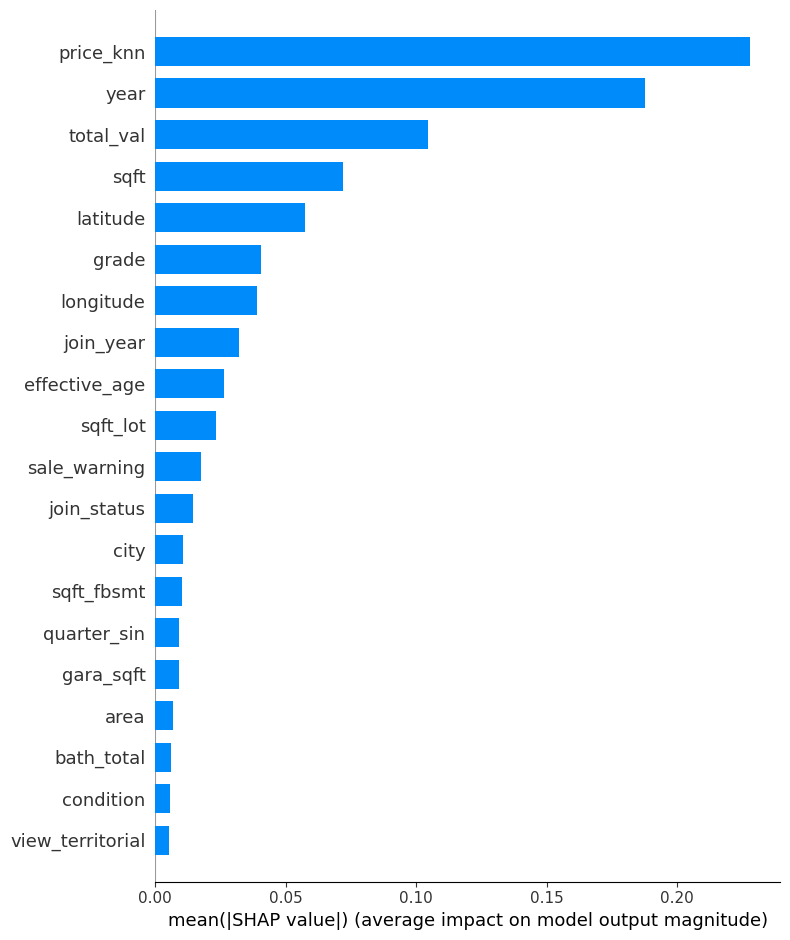

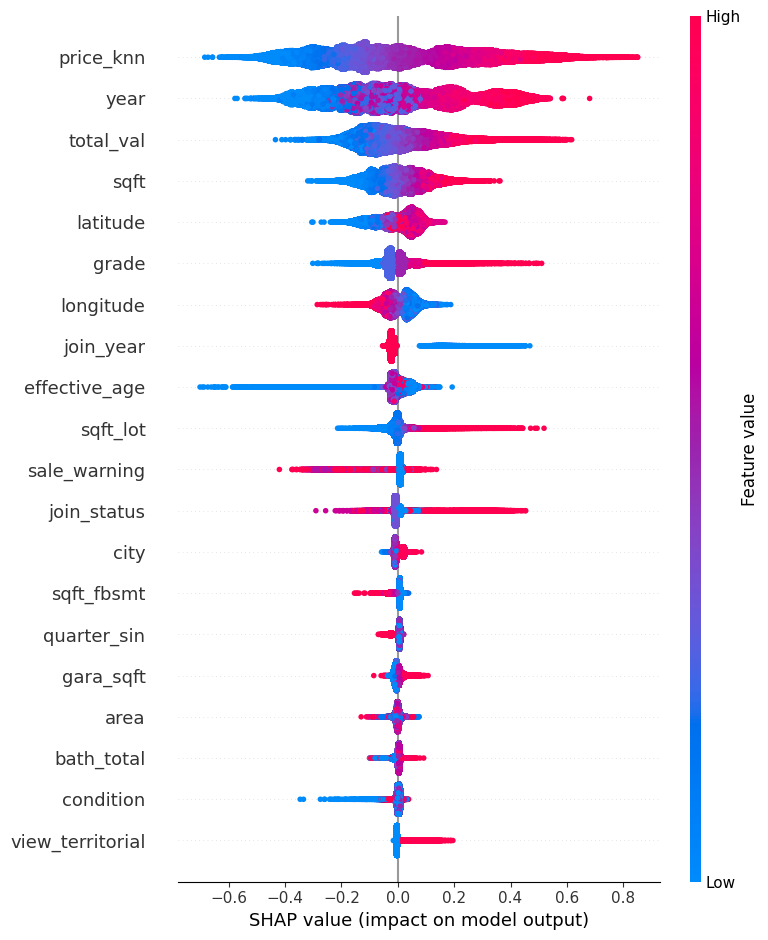

 Generating victory predictions...

 OPTIMIZED SUBMISSION CREATED!
 New OOF CV Score: 313,386
 Predicted LB: 320,690 (using 7,304 gap)
   id       pi_lower      pi_upper
0   0  779098.755806  1.034603e+06
1   1  531465.349574  8.310651e+05
2   2  427235.522273  6.155912e+05
3   3  315112.900475  4.450581e+05
4   4  452180.580217  8.444677e+05

 File saved: submission_optimized_gamma.csv


In [ ]:
# FINAL SUBMISSION

print(f"\n PROCEEDING WITH OPTIMIZED SUBMISSION")
print(" houseing final model on full dataset with optimized gammas...")
X_house, X_test = preprocess_knn_features(house, test, y_log, knn_features, knn_params)
final_model = uncert_model.fit(X_house[features], y_log)

# === SHAP ANALYSIS ===
print("\n Generating SHAP explanations...")
explainer = shap.TreeExplainer(final_model.model0)
shap_values = explainer.shap_values(X_house[features])
# 글로벌 요약 (바 플롯)
shap.summary_plot(shap_values, X_house[features], plot_type="bar")
# 상세 요약 (스캐터 플롯)
shap.summary_plot(shap_values, X_house[features])

print(" Generating victory predictions...")
# 예측 결과는 로그 스케일
y_hat_log, lower_log, upper_log = final_model.predict(X_test[features])
# 제출 전 원래 스케일로 변환
pi_lower = np.expm1(lower_log)
pi_upper = np.expm1(upper_log)
y_min, y_max = y.min(), y.max()
pi_lower, pi_upper = np.clip(pi_lower, y_min, y_max), np.clip(pi_upper, y_min, y_max)
submission_df = pd.DataFrame({'id': test.index, 'pi_lower': pi_lower, 'pi_upper': pi_upper})
submission_df.to_csv("submission_optimized_gamma.csv", index=False)

print(f"\n OPTIMIZED SUBMISSION CREATED!")
estimated_gap = 7304 # Using observed gap
predicted_lb = optimized_score + estimated_gap
print(f" New OOF CV Score: {optimized_score:,.0f}")
print(f" Predicted LB: {predicted_lb:,.0f} (using {estimated_gap:,.0f} gap)")
print(submission_df.head())
print(f"\n File saved: submission_optimized_gamma.csv")

In [ ]:
# 원본 id 를 갖고 있는 sample_submission.csv 불러오기
sample = pd.read_csv('sample_submission.csv')

# 기존 제출파일 불러오기
sub = pd.read_csv('submission_optimized_gamma.csv')

# id 컬럼만 교체
sub['id'] = sample['id']

# 덮어쓰기
sub.to_csv('submission_log_XGB.csv', index=False)

In [ ]:
# 파일 불러오기
sub_lgb = pd.read_csv('submission_log_LGB.csv')
sub_xgb = pd.read_csv('submission_log_XGB.csv')
sub_cat = pd.read_csv('submission_CAT.csv')

# 컬럼 이름 정리
sub_lgb  = sub_lgb.rename(columns={'pi_lower':'lgb_low',  'pi_upper':'lgb_up'})
sub_xgb  = sub_xgb.rename(columns={'pi_lower':'xgb_low',  'pi_upper':'xgb_up'})
sub_cat  = sub_cat.rename(columns={'pi_lower':'cat_low',  'pi_upper':'cat_up'})

# ID 기준으로 순차 병합
# 첫 번째 merge: LGBM + XGB
df = pd.merge(sub_lgb, sub_xgb, on='id')

# 두 번째 merge: (LGBM+XGB) + CAT
df = pd.merge(df, sub_cat, on='id')

# 가중치 설정 (합 = 1)
w_xgb, w_lgb, w_cat = 0.4, 0.5, 0.1


# 가중합으로 구간 생성
df['pi_lower'] = df['xgb_low']*w_xgb + df['lgb_low']*w_lgb + df['cat_low']*w_cat
df['pi_upper'] = df['xgb_up']* w_xgb + df['lgb_up']* w_lgb + df['cat_up']* w_cat

# 순서 및 클리핑 보정
df['pi_lower'], df['pi_upper'] = (
    np.minimum(df['pi_lower'], df['pi_upper']),
    np.maximum(df['pi_lower'], df['pi_upper'])
)
y_min, y_max = df[['xgb_low','lgb_low','cat_low','xgb_up','lgb_up','cat_up']].min().min(), \
               df[['xgb_low','lgb_low','cat_low','xgb_up','lgb_up','cat_up']].max().max()
df['pi_lower'] = df['pi_lower'].clip(y_min, y_max)
df['pi_upper'] = df['pi_upper'].clip(y_min, y_max)

# 결과 저장
submission = df[['id','pi_lower','pi_upper']]
submission.to_csv('submission_weighted_blend(3).csv', index=False)
print("✅ Weighted blend 제출 파일 생성: submission_weighted_blend(3).csv")

✅ Weighted blend 제출 파일 생성: submission_weighted_blend(3).csv


In [ ]:
submission.head()

,id,pi_lower,pi_upper
0,200000,796398.008358,1.035438e+06
1,200001,540137.266952,8.194228e+05
2,200002,440979.619224,6.412719e+05
3,200003,315092.090023,4.448537e+05
4,200004,418616.942943,8.445155e+05
